# Exploratory Analysis of Bike Data
In this project I will explore bike data from Ford GoBikes. I will focus on operational questions such as, how long are customers riding bikes, which stations are frequented the most, and if we can re-allocate bikes during the day where should we move bikes to? I'll try to learn as much as possible about how people use bikes using mainly plots

## Setup

In [1]:
# prerequisite package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime as datetime

%matplotlib inline

In [2]:
# Load dataset
bikes = pd.read_csv("201801-fordgobike-tripdata.csv")
print('starting', bikes.shape)
# load all 11 other 2018 files
for i in range(11):
    if i < 8:
        file = "20180"+str(i+2)+"-fordgobike-tripdata.csv"
    elif i >=8:
        file = "2018"+str(i+2)+"-fordgobike-tripdata.csv"
    bikes = bikes.append(pd.read_csv(file))
# print out the number of rows to confirm proper merge
print('ending', bikes.shape)

starting (94802, 16)
ending (1863721, 16)


In [3]:
bikes.info()
bikes.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863721 entries, 0 to 131362
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 241.7+ MB


(1863721, 16)

In [4]:
bikes.to_csv('bikes_master.csv', index=False)

In [ ]:
# use this line for faster load time, skip the merging
bikes = pd.read_csv('bikes_master.csv')

## Cleaning
##### Making a copy
First I want to make a copy of the data set so we can reference in case we make any changes we want to undo. Good data cleaning practice

In [24]:
bikes_copy = bikes.copy()

##### Add 'duration_min' column
Then I'll add a new column for duration in minutes for easy to read interpretation of trip duration.

In [25]:
bikes_copy['duration_min'] = bikes_copy['duration_sec']/60
bikes_copy.duration_min.describe()

count    1.863721e+06
mean     1.428838e+01
std      3.950631e+01
min      1.016667e+00
25%      5.833333e+00
50%      9.266667e+00
75%      1.453333e+01
max      1.439433e+03
Name: duration_min, dtype: float64

#### Convert String Dates into Datetime Objects
In order to plot usage over time, we'll need to access this column as a datetime object for ease on setting bins.

In [26]:
bikes_copy['start_time'] = pd.to_datetime(bikes_copy['start_time'])

##### Rearrange columns for visibility
Finally, I'll rearrange the columns a bit so the information I'm more interested in is closer to the left. We'll move the gps info all the way to the right and try to make use of that at a later time.

In [27]:
bikes_copy.columns
bikes_copy = bikes_copy[['duration_sec', 'duration_min', 'start_time', 'end_time', 'start_station_id',
       'start_station_name',  'end_station_id', 'end_station_name', 'bike_id', 'user_type', 'member_birth_year', 
        'member_gender', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude',
                          'bike_share_for_all_trip']]
bikes_copy.head()

,duration_sec,duration_min,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,bike_share_for_all_trip
0,75284,1254.733333,2018-01-31 22:52:35.239,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,285.0,Webster St at O'Farrell St,2765,Subscriber,1986.0,Male,37.761420,-122.426435,37.783521,-122.431158,No
1,85422,1423.700000,2018-01-31 16:13:34.351,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Pl...,15.0,San Francisco Ferry Building (Harry Bridges Pl...,2815,Customer,NaN,NaN,37.795392,-122.394203,37.795392,-122.394203,No
2,71576,1192.933333,2018-01-31 14:23:55.889,2018-02-01 10:16:52.1160,304.0,Jackson St at 5th St,296.0,5th St at Virginia St,3039,Customer,1996.0,Male,37.348759,-121.894798,37.325998,-121.877120,No
3,61076,1017.933333,2018-01-31 14:53:23.562,2018-02-01 07:51:20.5000,75.0,Market St at Franklin St,47.0,4th St at Harrison St,321,Customer,NaN,NaN,37.773793,-122.421239,37.780955,-122.399749,No
4,39966,666.100000,2018-01-31 19:52:24.667,2018-02-01 06:58:31.0530,74.0,Laguna St at Hayes St,19.0,Post St at Kearny St,617,Subscriber,1991.0,Male,37.776435,-122.426244,37.788975,-122.403452,No


There are a few outliers of bike rides going almost 24 hours which implies that the user forgot to end their trip or something odd happened. I'm gonna filter for rides less than 6 hours, which seems like a reasonable max for a bike ride. Since I'm mostly interested in San Francisco bike data, I will also filter our data set by GPS location.

In [28]:
# reduce rides lasting more than 6 hours
bikes_copy = bikes_copy.query("duration_min < 360")

# filter for gps location (inside SF)
bikes_copy = bikes_copy.query("start_station_latitude >= 37.707000 and start_station_latitude < 37.8100000 and start_station_longitude > -122.51000 and start_station_longitude <= -122.3700000")
bikes_copy = bikes_copy.query("end_station_latitude >= 37.707000 and end_station_latitude < 37.8100000 and end_station_longitude > -122.51000 and end_station_longitude <= -122.3700000")
bikes_copy.shape

(1360095, 17)

We have a lot of data still with over 1.3 million rows! To increase processing speed but still have similar demographics, I'm going to sample for a smaller data set. We'll sample with replacement so that our sample is indicative of the population.

In [30]:
sf_bikes = bikes_copy.sample(100000, replace=True)
sf_bikes.shape

(100000, 17)

# Univariate Exploration
- Bike Rental Duration
- Gender as a Proportion
- User Type as a Proportion
- Distribution of Age
- Usage by Hour
- Usage by Day of the Week
- Usage by Month

### Bike Rental Duration

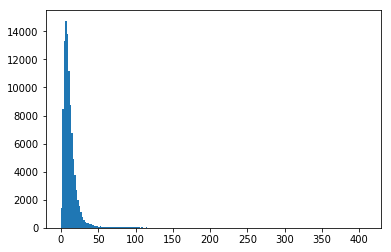

In [31]:
bin_edges = np.arange(0, sf_bikes['duration_min'].max()+50, 2)
plt.hist(data = sf_bikes, x = 'duration_min', bins=bin_edges);

We have a right skewed distribution but there are some extreme values on the right that make it hard to see our distribution in detail. It seems most values fall between the 0 to 80 minute mark. We'll adjust our xlim to better observe these values.

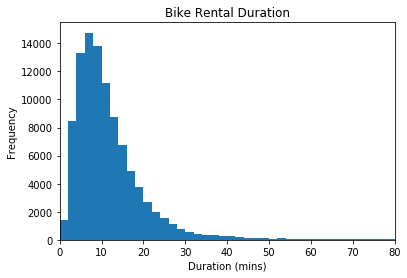

In [32]:
bin_edges = np.arange(0, sf_bikes['duration_min'].max()+50, 2)
plt.hist(data = sf_bikes, x = 'duration_min', bins=bin_edges)
plt.xlim(0, 80)
plt.title('Bike Rental Duration')
plt.xlabel('Duration (mins)')
plt.ylabel('Frequency');

Now we can defnitely see that most trips before the 20 minute mark but a good amount of trips can also extend towards the hour mark.

### Gender as a Proportion

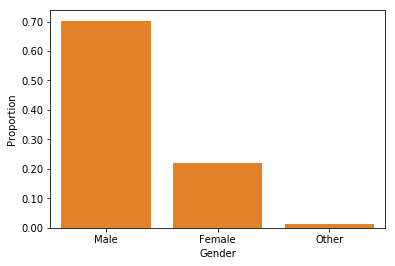

In [33]:
n_points = sf_bikes.shape[0]
max_count = sf_bikes['member_gender'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop+0.1, 0.10)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[1]
plt.yticks(tick_props * n_points, tick_names)
sb.countplot(data = sf_bikes, x = 'member_gender', color = base_color)
plt.ylabel('Proportion')
plt.xlabel('Gender');

Most riders are male at about 70% of users. About 20% of users are female and a small percentage identified as other.

### Rider Age Distribution

Now we'll look at the age distribution of our riders. First we'll have to create a new age column using the 'member birty year' data.

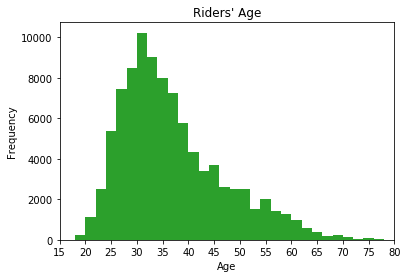

In [34]:
base_color = sb.color_palette()[2]
sf_bikes['age'] = 2019 - sf_bikes['member_birth_year']
bin_edges = np.arange(0, sf_bikes['age'].max()+1, 2)
plt.hist(data = sf_bikes, x = 'age', bins=bin_edges, color = base_color)
plt.xticks([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
plt.xlim(0, 80)
plt.title("Riders' Age")
plt.xlabel('Age')
plt.xlim(15, 80) # Riders need to be at least 18 to use program
plt.ylabel('Frequency');

Seems our rider's age is right skewed with the median around 30-32. Riders must be 18 to sign up so it makes sense that we don't have riders below that age. While the peak is around early 30's, theres' a fair amount of riders across all ages.

### Rider User Type

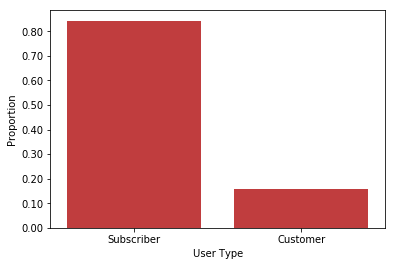

In [35]:
n_points = sf_bikes.shape[0]
max_count = sf_bikes['user_type'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop+0.1, 0.10)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[3]
plt.yticks(tick_props * n_points, tick_names)
sb.countplot(data = sf_bikes, x = 'user_type', color = base_color)
plt.ylabel('Proportion')
plt.xlabel('User Type');

Wow, a lot of users are subscribers. Most people who use the gobikes tend to be loyal customers, at least in 2018.

### Usage Throughout the Day

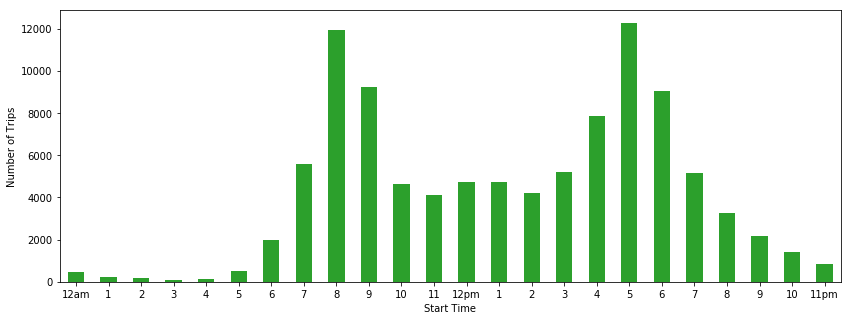

In [36]:
plt.figure(figsize = (14,5))
base_color = sb.color_palette()[2]
# hours = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
#         '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']
hours = ['12am', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
        '12pm', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11pm']
sf_bikes.groupby(sf_bikes.start_time.dt.hour).bike_id.count().plot(kind='bar', color = base_color);
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
# get xtick labels
labs = ax.get_xticklabels()
# change the xticks
plt.xticks(pos,hours, rotation = 'horizontal')
plt.xlabel('Start Time')
plt.ylabel('Number of Trips');

Trips seem to peak around commute hours. It seems people might use them for their last mile to get to a train or work. There's some nice consistent amount of trips during work hours as well.

### Usage By Day of the Week

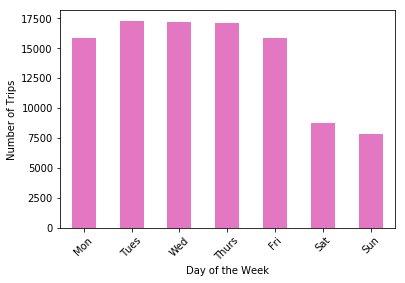

In [37]:
base_color = sb.color_palette()[6]
weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
sf_bikes.groupby(sf_bikes.start_time.dt.weekday).bike_id.count().plot(kind='bar', color = base_color)
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
# get xtick labels
labs = ax.get_xticklabels()
# change the xticks
plt.xticks(pos,weekdays, rotation = '45')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips');

Here we see consistent high usage during the week which could support that people are using gobikes for their commutes. Usage drops down to about half the rate during weekends where we might see more leisure rides.

### Usage By Month

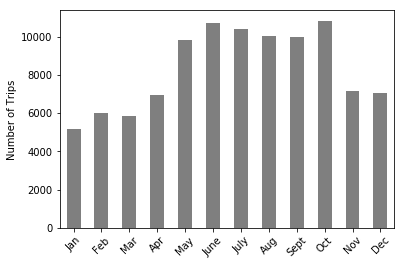

In [39]:
base_color = sb.color_palette()[7] 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
sf_bikes.groupby(sf_bikes.start_time.dt.month).bike_id.count().plot(kind='bar', color = base_color)
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
# get xtick labels
labs = ax.get_xticklabels()
# change the xticks
plt.xticks(pos,months, rotation = '45')
plt.xlabel('')
plt.ylabel('Number of Trips');

Looking at usage over the year, it seems riders tend to use the bikes more during the warmer months. Interesting to see that November and December have higher usage than January, February, and March. The latter seasons might be more wet seasons in San Francisco which could deter riders.

# Bivariate Exploration

### Exploring Age and Trip Duration

Start with Scatterplot

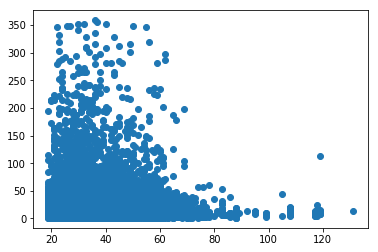

In [40]:
plt.scatter(data = sf_bikes, x = 'age', y = 'duration_min', );

We have a lot of data so lets introduce some jitter and adjust alpha values to learn more about the density of our data.

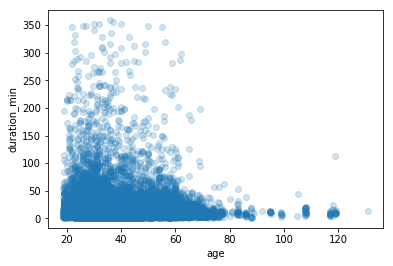

In [42]:
sb.regplot(data = sf_bikes, x = 'age', y = 'duration_min', fit_reg = False, 
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/5});

Even with jitter and adjusting alpha values, its hard to take much from the scatter plot other than there's a lot of values in the in the bottom left of the plot. A heat map could give us a better idea of the density of the spread in this area.

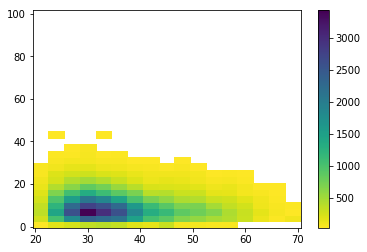

In [43]:
bins_x = np.arange(19.6, 70.5+3, 3)
bins_y = np.arange(-0.5, 100.5+3, 3)
plt.hist2d(data = sf_bikes, x = 'age', y = 'duration_min',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 35)
plt.colorbar()

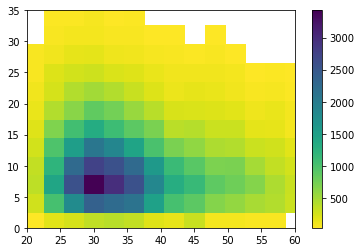

In [44]:
plt.hist2d(data = sf_bikes, x = 'age', y = 'duration_min',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 35)
plt.colorbar()
plt.xlim(20, 60)
plt.ylim(0, 35);

Look at this heat map, we can see that there are a lot of trips within the 5 to 15 minute range which is true for most riders between the ages of 20 to 45 years old. We'll do a bar chart by age to see if there's a particular age group that rides longer. We'll limit our values for age groups below 90 years old. While elderly folk may be getting a great work out, it seems more likely that someone made a typo if they were report ages higher than 90 or 100 years old.

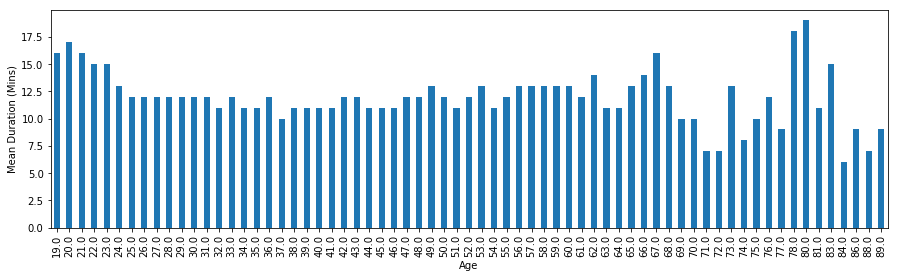

In [46]:
# age_grouped = bikes_clean[['age', 'duration_min']]
#age_grouped = bikes_clean.groupby(bikes_clean.age).duration_min.mean()
plt.figure(figsize = (15,4))
base_color = sb.color_palette()[0]
# trimming our data set for more realistic age values. Had some unlikely values above 90
sf_bikes = sf_bikes.query('age <= 90')
sf_bikes.groupby(sf_bikes.age).duration_min.mean().astype(int).plot(kind='bar', color = base_color)
plt.xlabel('Age')
plt.ylabel('Mean Duration (Mins)');

These values are farily consistent across age groups with a few spikes for the younger kids and again with those near 80 years old.

### Violin Plot of Payment Type and Duration of Trip

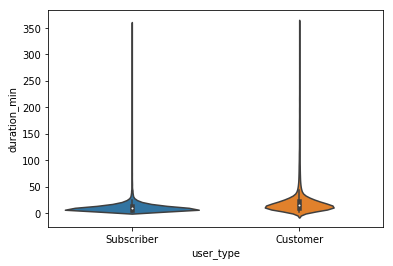

In [47]:
sb.violinplot(data = sf_bikes, x = 'user_type', y = 'duration_min');

Our violin plot seems to be skewed by some extreme duration values again. So let's limit our view to get a closer look at our spread.

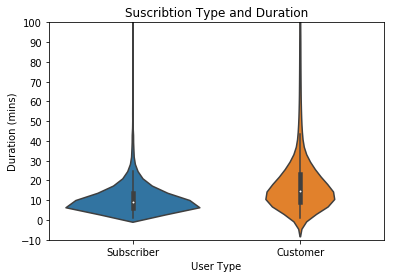

In [48]:
sb.violinplot(data = sf_bikes, x = 'user_type', y = 'duration_min');
plt.ylim(-10, 100)
plt.title("Suscribtion Type and Duration")
plt.xlabel('User Type')
plt.yticks([-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel('Duration (mins)');

Here we can start to see a nice distinction between user type. It seems like there is a cut off for subscribers around the 10 to 15 minute marke where I believe their membership allows unlimited rides unless they pass a certain point. For customers, I believe the payment method allows for a flat rate for the first 30 mins and then charges for each subsequent 15 mins beyond the initial 30 mins. As a result, these customers' mean duration result in a wider spread for their trips.

In [52]:
sf_bikes.query("user_type == 'Subscriber'").duration_min.describe()

count    82321.000000
mean        10.938416
std         10.181151
min          1.016667
25%          5.866667
50%          9.050000
75%         13.483333
max        358.833333
Name: duration_min, dtype: float64

In [53]:
sf_bikes.query("user_type == 'Customer'").duration_min.describe()

count    11123.000000
mean        22.311616
std         30.573820
min          1.016667
25%          9.316667
50%         14.616667
75%         23.041667
max        355.633333
Name: duration_min, dtype: float64

### Time series plot of avg trip duration over the course of a day (aka line plot)

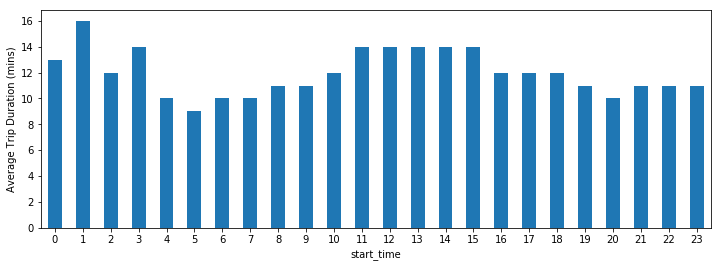

In [56]:
plt.figure(figsize = (12, 4))
sf_bikes.groupby(sf_bikes.start_time.dt.hour).duration_min.mean().astype(int).plot(kind='bar', color = base_color)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Average Trip Duration (mins)');

Average trip duration is fairly consistent throughout the day. Lets see the same plot but this time as a time series plot.

In [58]:
# creat new hour column so we can groupby hour and compute average duration
sf_bikes['hour'] = sf_bikes.start_time.dt.strftime("%H")

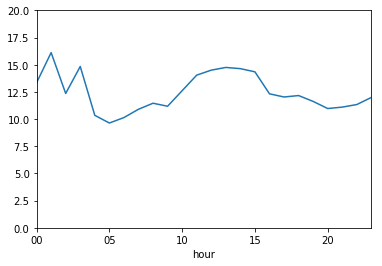

In [60]:
sf_bikes.groupby("hour")["duration_min"].mean().plot()
plt.ylim(0, 20);

Time series plot makes it pretty easy to see a dip before 5am with a steady rise into the day time when the weather is getting warmer. However, people tend to adhere to the 'less than 15 minute' rule to avoid extra charges on their ride. This doesn't allow for much fluctuation in average trip duration.

### Average Trip Duration Across the Year

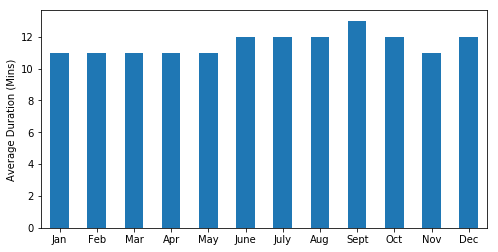

In [61]:
plt.figure(figsize = (8, 4))
# months = ['June', 'July', 'August', 'September', 'October', 'November', 'December']
sf_bikes.groupby(sf_bikes.start_time.dt.month).duration_min.mean().astype(int).plot(kind='bar', color = base_color)
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
plt.xticks(pos, months, rotation = 'horizontal')
plt.xlabel('')
plt.ylabel('Average Duration (Mins)');

Once again, we'll look at this bar chart as a time series plot grouping by day

In [62]:
sf_bikes['day_year'] = sf_bikes.start_time.dt.strftime("%d-%b-%Y")

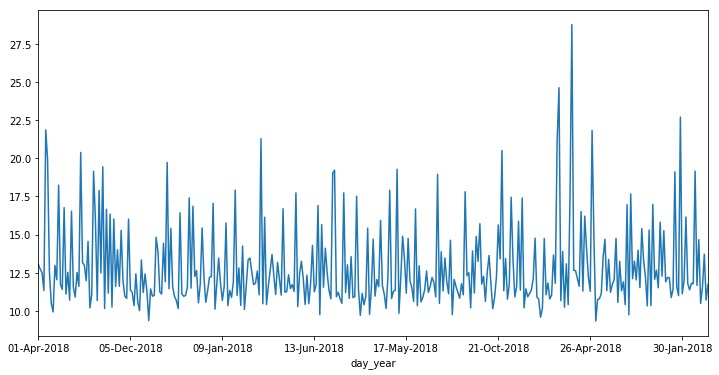

In [64]:
plt.figure(figsize = (12, 6))
sf_bikes.groupby('day_year')['duration_min'].mean().plot();

Grouping by day gives us a very fuzzy plot which makes it hard to see how the values change over the year. For some reason, the months aren't laid out in the usual calendar order. We'll make another time series plot by month and make sure they're ordered properly.

#### Time Series Average Trip Duration Over Year

In [67]:
sf_bikes['month'] = sf_bikes.start_time.dt.strftime("%B")
months_order = ['January', 'February', 'March', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_classes = pd.api.types.CategoricalDtype(ordered = True, categories = months_order)
sf_bikes['month'] = sf_bikes['month'].astype(month_classes);

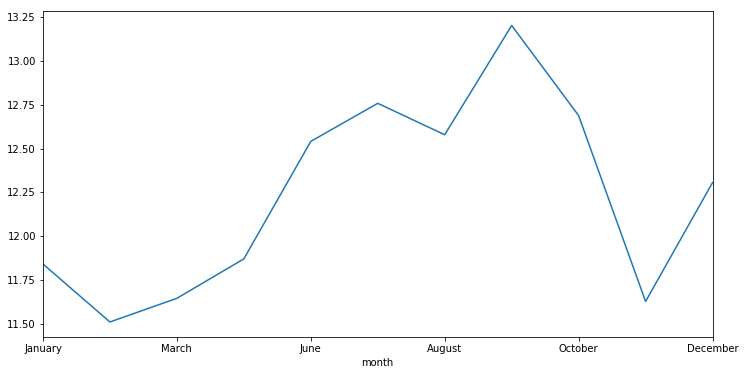

In [68]:
plt.figure(figsize = (12, 6))
sf_bikes.groupby("month")["duration_min"].mean().plot();

At first glance, the resulting time series plot looks like there's a significant increase and drop in trip duration. Our y-values are fairly zoomed in. Lets see again what the plot looks like when we start with zero.

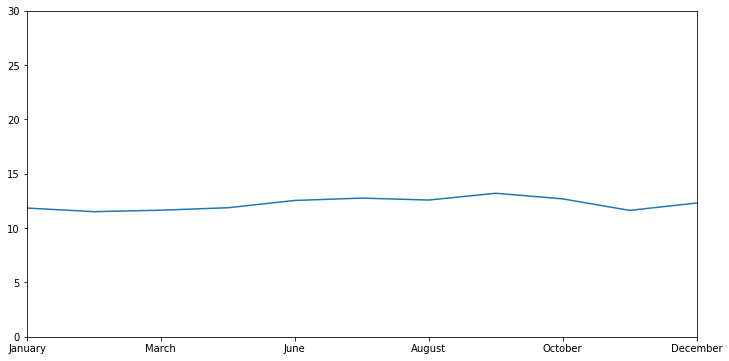

In [69]:
plt.figure(figsize = (12, 6))
sf_bikes.groupby("month")["duration_min"].mean().plot()
plt.ylim(0, 30)
plt.xlabel('');

When we plot starting with zero, we can see that there isn't much fluctuation in trip duration over the year. Slightly higher in the summer months but not by too much.

# Multivariate Exploration

Let's look at the average trip duration now but factor in user type and time of year. We should expect a higher average and distribution for customer users than subscribers.

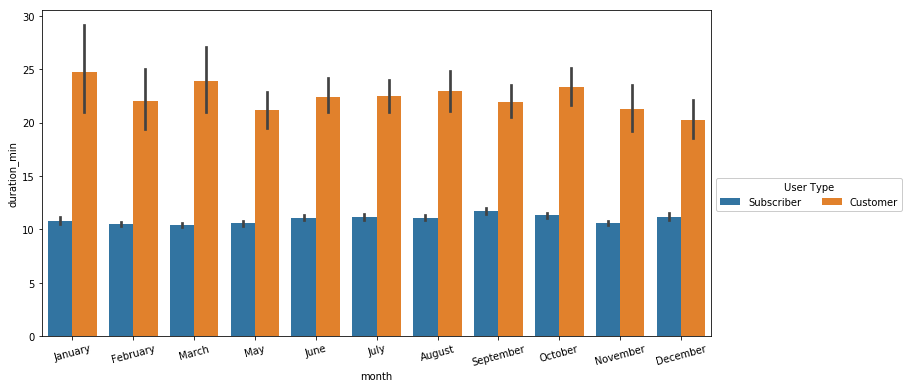

In [71]:
plt.figure(figsize = (12, 6))
ax = sb.barplot(data = sf_bikes, x = 'month', y = 'duration_min', hue = 'user_type')
ax.legend(loc = 0, ncol = 3, framealpha = 1, title = 'User Type', bbox_to_anchor = (1.0, 0.5));
plt.xticks(rotation = 15);

This bar chart is fairly interesting. Non-subscription users tend to be significantly more flexible with their trips but still keep their trips shorter than 30 mins on average (which I'm more sure now is the cap before trips become more expensive). The error bar for non-subscribers is also much large compared to the very small error bar for subscribers. Now I'm fairly certain that subscribers need to end their rides at 10 mins to avoid being charged extra fees. It's difficult to know for certain because their payment model may have been different last year. The current model allows subscribers unlimited 45 minute rides which doesn't seem to add up with this data set.

In [72]:
sf_bikes.duration_min.describe()

count    93444.000000
mean        12.292212
std         14.701721
min          1.016667
25%          6.133333
50%          9.500000
75%         14.400000
max        358.833333
Name: duration_min, dtype: float64

### Average Usage by Day of the Week and Gender

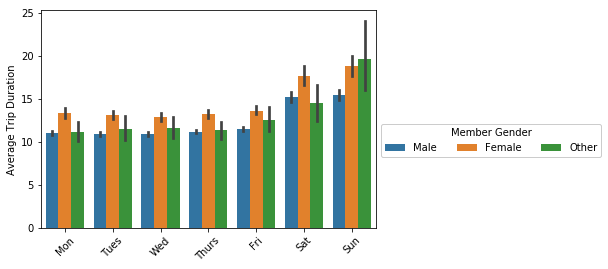

In [73]:
weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
sf_bikes['day'] = sf_bikes.start_time.dt.weekday
ax = sb.barplot(data = sf_bikes, x = 'day', y = 'duration_min', hue = 'member_gender')
ax.legend(loc = 0, ncol = 3, framealpha = 1, title = 'Member Gender', bbox_to_anchor = (1.0, 0.5));
axis = plt.gca()
# get xtick positions
pos = axis.get_xticks().tolist()
plt.xticks(pos, weekdays, rotation = '45')
plt.xlabel('')
plt.ylabel('Average Trip Duration');

Females tend to ride longer regardless of the day including weekends but not by too much. One interesting thing about this plot is the large error rate for the people identifying as other on Sunday. Let's do a facet violin plot to learn more about average trip distribution by gender.

C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


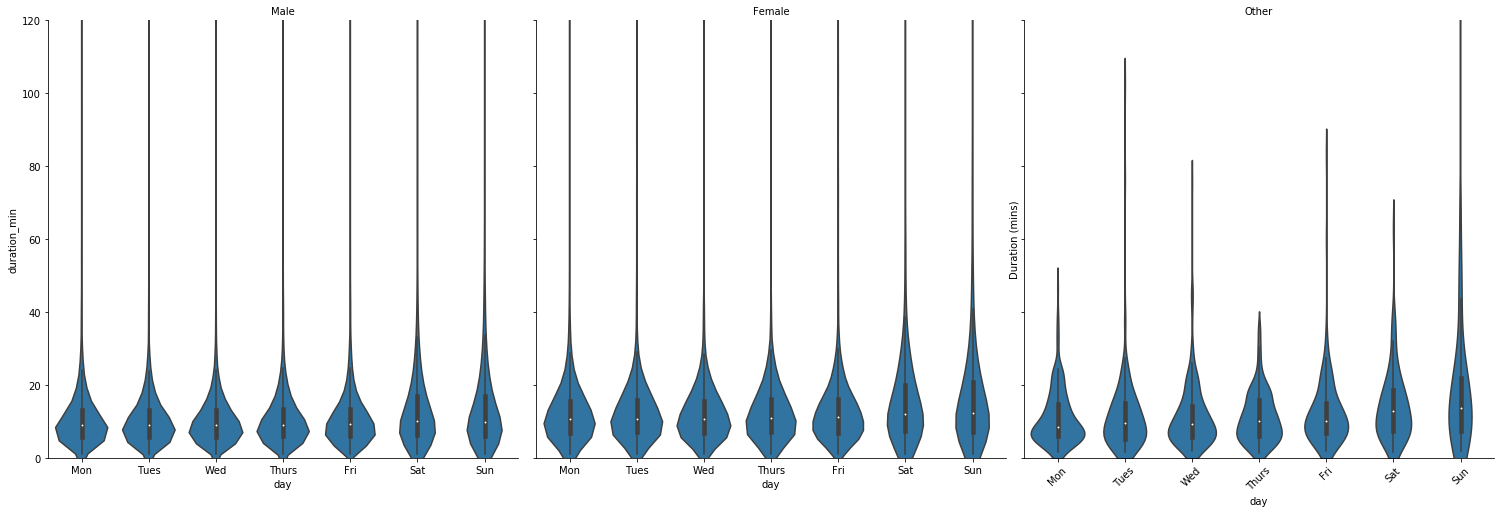

In [74]:
# plotting
bin_edges = np.arange(0, sf_bikes['duration_min'].max()+50, 2)
g = sb.FacetGrid(data = sf_bikes, col = 'member_gender', height = 7, col_wrap = 3)
g.map(sb.violinplot, 'day', 'duration_min')
g.set_titles('{col_name}')
axis = plt.gca()
# get xtick positions
pos = axis.get_xticks().tolist()
plt.xticks(pos, weekdays, rotation = '45')
plt.ylim(0, 120)
plt.ylabel("Duration (mins)");

The resulting violin plots show a very skewed distribution Sunday for the group identifying as other. This can potentially be explained by the size of our sample. Groups identifying as other made a small percentage of users and now that we're filtering by day as well, outliers can have more weight on these distribution. But in general, Saturday and Sunday have 'skinnier' distributions which reflects that people are going for longer rides and not restricting themselves to the 30 minute cut-off as much as during the week.

### Using a Heat Map to Observe Commute Hours

First we'll create two dataframes to host the commute traffic.

In [75]:
# AM commute 7am to 10am
AM = sf_bikes.query("start_time.dt.hour >= 7 and start_time.dt.hour <= 10")

# PM commute 3pm to 6pm
PM = sf_bikes.query("start_time.dt.hour >= 15 and start_time.dt.hour <= 18")

### AM Commute Heat Map

I tried to run the heatmap with our 100,000 data set and the cell would crash. In order to avoid crashing the cell with too many rows, I decided to sample once more with replacement to get dataframe that won't overload the cell. I'll do this for both the AM and PM data sets before plotting the heatmap.

In [80]:
bikes_short = AM.sample(3000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747],
                    zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = bikes_short[['start_station_latitude', 'start_station_longitude']]
heat_df = bikes_short.dropna(axis=0, subset=['start_station_latitude', 'start_station_longitude'])

# List comprehension to make out list of lists
heat_data = [[row['start_station_latitude'],row['start_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(sf)

# Display the map
sf

In the morning, there are rides starting at almost every gobike location in San Francisco. Heavy usage in areas close to Market which could be linking riders to/from Bart. Lots of usage in Soma close to the Cal Train 4th and King station. Overall, there's a fair spread across San Francisco. This is a very busy and consistent spread of bike usage! Next lets look at where rides end in the morning to confirm if riders are using this to connect to other transit systems.

In [81]:
# sample smaller set for easier loading
AM_end = AM.sample(3000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747], zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = PM_end[['end_station_latitude', 'end_station_longitude']]
heat_df = PM_end.dropna(axis=0, subset=['end_station_latitude', 'end_station_longitude'])
# List comprehension to make out list of lists
heat_data = [[row['end_station_latitude'],row['end_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map and display
HeatMap(heat_data).add_to(sf)
sf

This heat map spread shows where rides end. It seems that bikes spread out again to more neighborhoods in San Francisco. This could reflect commuters using the gobikes for their last mile on the way to school, work, or another activity.

## PM Commute Map
Bike rides start between 3pm to 6pm

In [82]:
bikes_short = PM.sample(3000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747],
                    zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = bikes_short[['start_station_latitude', 'start_station_longitude']]
heat_df = bikes_short.dropna(axis=0, subset=['start_station_latitude', 'start_station_longitude'])

# List comprehension to make out list of lists
heat_data = [[row['start_station_latitude'],row['start_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(sf)

# Display the map
sf

The PM commute starting ride locations looks very similar to the AM start locations. Most rides beging near downtown, areas near Market, SOMA, and northern Potrero Hill. Lets see where PM rides end. Should see riders spread back out into neighborhoods and transit locations.

In [83]:
# sample smaller set for easier loading
PM_end = PM.sample(3000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747], zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = PM_end[['end_station_latitude', 'end_station_longitude']]
heat_df = PM_end.dropna(axis=0, subset=['end_station_latitude', 'end_station_longitude'])
# List comprehension to make out list of lists
heat_data = [[row['end_station_latitude'],row['end_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map and display
HeatMap(heat_data).add_to(sf)
sf

The PM commute end locations aren't as distributed as the AM commute end locations. It seems like most people are using the bikes to get to Bart and Cal Train locations to begin their commute back home.